In [1]:
"""
Expects a csv file with image id, maxlat, maxlon, minlat, minlon of each satellite image
Expects json files as a folder with the polygons parsed from the shapefile
Expects images for overlaying masks on images

"""

import json
import numpy as np
import pandas as pd
import sys
import os
import cv2
import imageio
import csv
import matplotlib.pyplot as plt
from PIL import Image
import os
from collections import defaultdict 

# Helper functions

In [2]:
def create_empty_overlays(grid, orig_images_dir, prefix='', suffix='', n=100):
    """
    Initiate empty masks and original images into the output folder based on the
    
    Args:
        grid (list): information from csv, so the empty masks to be overwritten later
    """
    for index in range(len(grid.keys())):
        image_id = str(grid[index]['image_id']).zfill(5)
        if image_id >= str(n).zfill(5):
            break
            
        im_name = os.path.join(orig_images_dir, str(prefix) + str(image_id) + str(suffix) + '.tif')
        orig_image = cv2.imread(im_name)
        overlay_path = os.path.join(base_dir, overlay_folder, str(image_id) + '.jpeg')
        cv2.imwrite(overlay_path, orig_image)

def create_dict_parcels(shp_dict):
    """
    Put the found fields from the parsed json into dict of image ids
    Args:
        shp_dict (dict): json dict containing the polygon fields

    Returns:
        dict: contains image id to polygons
    """
    dict_parcels = defaultdict(list) 
    for sh_index, sh in enumerate(shp_dict['features']):
        id_list = sh['properties']['image_id']
        for image_id in id_list:
            dict_parcels[image_id].append(sh)
    return dict_parcels

def scale_coords(shape_size, geom, grid, index):
    """
    scales the polygons lat/lon to pixel 
    Args:
        shape_size (tuple): size of the image to be scaled to
        geom (polygon): field polygon
        grid (list): values of min/max lat/lon for each image id
        index (int): Index of each image id in grid

    Returns:
        list: scaled coordinates
    """
    w, h = shape_size
    min_lat, min_lon, max_lat, max_lon = grid[index]['min_lat'], grid[index]['min_lon'], \
        grid[index]['max_lat'], grid[index]['max_lon']
    x = geom[:,0]
    y = geom[:,1]
    scale_lon = w/(max_lon - min_lon)
    scale_lat = h/(max_lat-min_lat)
    scaled_x = (x - min_lon) * scale_lon # lon-> x, lat->y
    scaled_y = h - ((y - min_lat) * scale_lat)
    if any(val > w for val in scaled_x) or any(val > h for val in scaled_y) \
        or any(val < 0 for val in scaled_x) or any (val < 0 for val in scaled_y):
        return np.concatenate([scaled_x[:,None], scaled_y[:,None]],axis=1)
    return np.concatenate([scaled_x[:,None], scaled_y[:,None]],axis=1)

# Setup

In [3]:
def get_grid(df):
    """
    Read the CSV file containing minmax lat/lon and stores it to a 2D list

    Args:
        df: pandas dataframe of bounding boxes

    Returns:
        list: contains the imag_id and lat/long information
    """
    grid = dict()
    keys = ['max_lat', 'max_lon', 'min_lat', 'min_lon']

    for index, row in df.iterrows():
        if index not in grid:
            grid[index] = dict()
        grid[index]['image_id'] = row['image_id']
        grid[index]['max_lat'] = float(row['max_lat'])
        grid[index]['max_lon'] = float(row['max_lon'])
        grid[index]['min_lat'] = float(row['min_lat'])
        grid[index]['min_lon'] = float(row['min_lon'])
        
    return grid

In [32]:
# ======================== USER SETUP ======================== #
# Directories to read the necessary files from

# SENEGAL
base_dir = '../data/planet/senegal/'
json_file = '../data/planet/senegal/json_polys/bbox_tiles_0_3293.json'
year = 2019

# MALAWI
# base_dir = '../data/planet/malawi'
# json_file = '../data/planet/malawi/json_polys/bbox_tiles_0_499.json'
# year = 2018

# GHANA
# base_dir = '../data/planet/ghana/udry'
# json_file = '../data/planet/ghana/udry/json_polys/bbox_tiles_0_111334.json'
# year = 2017

label_folder = 'extent_labels/'
overlay_folder = 'overlays/'

csv_file = os.path.join(base_dir, 'bbox_tiles_overlap.csv')
orig_images_dir = os.path.join(base_dir, 'monthly_mosaics_renamed_clipped_merged', 
                               '{}_10'.format(year))

year_month = '_{}_10'.format(year)
thickness = 2
# ============================================================ #

df = pd.read_csv(csv_file)
df['image_id'] = df['image_id'].astype(str).str.zfill(5)
grid = get_grid(df)

# Run label generation

In [18]:
# create output directory if not exist
if os.path.exists(os.path.join(base_dir, label_folder)) == False:
    os.makedirs(os.path.join(base_dir, label_folder))
if os.path.exists(os.path.join(base_dir, overlay_folder)) == False:
    os.makedirs(os.path.join(base_dir, overlay_folder))

In [19]:
create_empty_overlays(grid, orig_images_dir, suffix='_{}_10'.format(year), n=200)
# TODO: pull planet imagery

In [20]:
count_parcels = defaultdict(int)
num_fields_parsed = 0

# read multiple json files
print('Read json', json_file)

# open the saved json file for the found parcels in the images 
with open(json_file) as f:
    shp_dict = json.load(f)

# create dictionary of polygons in each image for fast indexing
parcels_dict = create_dict_parcels(shp_dict)

# find the polygons of each image and plot them
for index in range(len(grid.keys())):

    image_id = grid[index]['image_id']
    polys = []
    if image_id in parcels_dict:
        img = imageio.imread(os.path.join(orig_images_dir, str(image_id) + year_month + '.tif'))
        shape_size = (img.shape[0], img.shape[1])
        extent_path = os.path.join(base_dir, label_folder, str(image_id) + '.png')
        extent_label = np.zeros(shape_size)

        for sh_index, sh in enumerate(parcels_dict[image_id]):
            count_parcels[image_id] += 1 
            for coord_idx in range(len(sh['geometry']['coordinates'])):
                geom = np.array(sh['geometry']['coordinates'][coord_idx])
                try:
                    geom_fixed = scale_coords(shape_size, geom, grid, index)
                except:
                    print("Exception in image {}".format(image_id))
                    print(geom)
                pts = geom_fixed.astype(int)
                cv2.fillPoly(extent_label, [pts], color=1)
                polys.append(pts)

        # Save the extent label
        cv2.polylines(extent_label, polys, True, color=0, thickness=thickness)
        cv2.imwrite(extent_path, extent_label)

        # Saves the overlay file
        overlay_path = os.path.join(base_dir, overlay_folder, str(image_id) + '.jpeg')
        orig_image = cv2.imread(os.path.join(orig_images_dir, str(image_id) + year_month + '.tif'))
        cv2.imwrite(overlay_path, orig_image)
        orig_image = cv2.imread(overlay_path)
        cv2.polylines(orig_image, polys, True, color=(255,255,255), thickness=thickness)
        cv2.imwrite(overlay_path, orig_image)
#         print('saved image ', image_id)

Read json ../data/planet/malawi/json_polys/bbox_tiles_0_499.json


## Verify labels

### Senegal

In [33]:
df.shape

(607, 5)

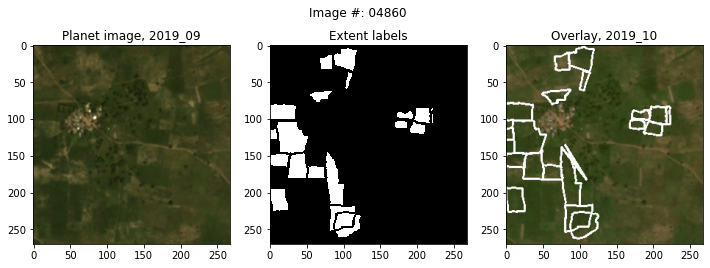

In [34]:
fig, ax = plt.subplots(1,3, figsize=(12,4))

image_id = np.random.choice(df['image_id'].values)
ymonth = '2019_09'

mask = imageio.imread('../data/planet/senegal/monthly_mosaics_renamed_clipped_merged/{}/{}.tif'.format(
    ymonth, image_id + '_' + ymonth))
ax[0].imshow(mask)
ax[0].set_title('Planet image, {}'.format(ymonth))

extent = imageio.imread('../data/planet/senegal/extent_labels/{}.png'.format(image_id))
ax[1].imshow(extent, cmap='Greys_r', interpolation='nearest', vmin=0, vmax=1)
ax[1].set_title('Extent labels')

overlay = imageio.imread('../data/planet/senegal/overlays/{}.jpeg'.format(image_id))
ax[2].imshow(overlay)
ax[2].set_title('Overlay, 2019_10')

fig.suptitle("Image #: {}".format(image_id))

plt.show()

### Malawi

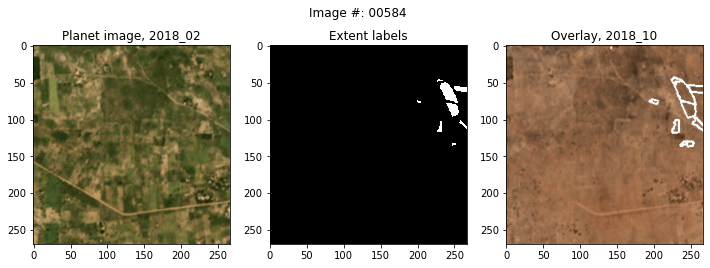

In [22]:
fig, ax = plt.subplots(1,3, figsize=(12,4))

image_id = np.random.choice(df['image_id'].values)
ymonth = '2018_02'

mask = imageio.imread('../data/planet/malawi/monthly_mosaics_renamed_clipped_merged/{}/{}.tif'.format(
    ymonth, image_id + '_' + ymonth))
ax[0].imshow(mask)
ax[0].set_title('Planet image, {}'.format(ymonth))

extent = imageio.imread('../data/planet/malawi/extent_labels/{}.png'.format(image_id))
ax[1].imshow(extent, cmap='Greys_r', interpolation='nearest', vmin=0, vmax=1)
ax[1].set_title('Extent labels')

overlay = imageio.imread('../data/planet/malawi/overlays/{}.jpeg'.format(image_id))
ax[2].imshow(overlay)
ax[2].set_title('Overlay, 2018_10')

fig.suptitle("Image #: {}".format(image_id))

plt.show()

### Ghana

#### 2019

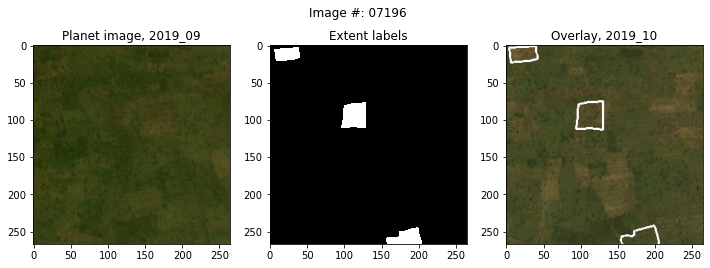

In [9]:
fig, ax = plt.subplots(1,3, figsize=(12,4))

# image_id = np.random.choice(df['image_id'].values)
image_id = '07196'
ymonth = '2019_09'

mask = imageio.imread('../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged_2019/{}/{}.tif'.format(
    ymonth, image_id + '_' + ymonth))
ax[0].imshow(mask)
ax[0].set_title('Planet image, {}'.format(ymonth))

extent = imageio.imread('../data/planet/ghana/udry/extent_labels/{}.png'.format(image_id))
ax[1].imshow(extent, cmap='Greys_r', interpolation='nearest', vmin=0, vmax=1)
ax[1].set_title('Extent labels')

overlay = imageio.imread('../data/planet/ghana/udry/overlays/{}.jpeg'.format(image_id))
ax[2].imshow(overlay)
ax[2].set_title('Overlay, 2019_10')

fig.suptitle("Image #: {}".format(image_id))

plt.show()

#### 2017

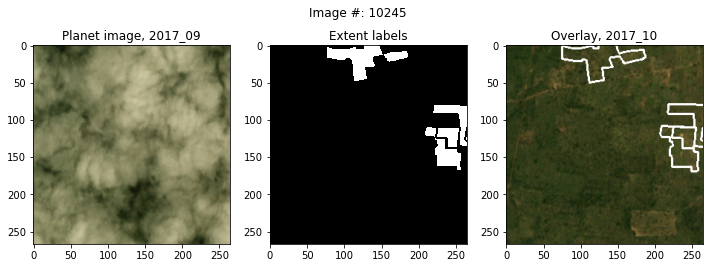

In [24]:
fig, ax = plt.subplots(1,3, figsize=(12,4))

# image_id = np.random.choice(df['image_id'].values)
image_id = '10245'
ymonth = '2017_09'

mask = imageio.imread('../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/{}/{}.tif'.format(
    ymonth, image_id + '_' + ymonth))
ax[0].imshow(mask)
ax[0].set_title('Planet image, {}'.format(ymonth))

extent = imageio.imread('../data/planet/ghana/udry/extent_labels/{}.png'.format(image_id))
ax[1].imshow(extent, cmap='Greys_r', interpolation='nearest', vmin=0, vmax=1)
ax[1].set_title('Extent labels')

overlay = imageio.imread('../data/planet/ghana/udry/overlays/{}.jpeg'.format(image_id))
ax[2].imshow(overlay)
ax[2].set_title('Overlay, 2017_10')

fig.suptitle("Image #: {}".format(image_id))

plt.show()